In [1]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()
print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...


In [2]:
def initspark():
    spark = SparkSession.builder.appName('mlonspark')\
        .config('spark.executor.instances', '3')\
        .getOrCreate()
    print('pyspark ready ...')
    return spark

In [3]:
from mlonspark import AlternatingLeastSquare
def initalg(val):
    return AlternatingLeastSquare()\
    .setUserCol("userId")\
    .setItemCol("artistId")\
    .setRatingCol("stdCountPos")\
    .setRank(25)\
    .setRegParam(val)\
    .setImplicitPrefs(True)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot(res):
    x = []
    yTrain = []
    yTest = []
    for v in res:
        x.append(v[0])
        yTrain.append(v[1])
        yTest.append(v[2])

    plt.figure(figsize=(8,4))
    plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
    plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
    plt.legend(loc="upper left", fontsize=15)
    plt.ylabel("RMSE", fontsize=18)

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan

def runtest(rng, **model_kargs):
    res = []
    for i in rng:
        spark = initspark();
        train = spark.read.load("/data/lastfm-dataset-360K/data-filtered-std-pos-train.parquet")
        test = spark.read.load("/data/lastfm-dataset-360K/data-filtered-std-pos-test.parquet")
        
        evaluator = RegressionEvaluator()\
            .setMetricName("rmse")\
            .setLabelCol("stdCountPos")\
            .setPredictionCol("prediction")
        
        alg = initalg(i)
        model = alg.fit(train)
        trainPredictions = model.transform(train)
        trainPredictionsFiltered = trainPredictions.where(~isnan(col("prediction")))  
        trainRmse = evaluator.evaluate(trainPredictionsFiltered)
        
        
        testPredictions = model.transform(test)
        testPredictionsFiltered = testPredictions.where(~isnan(col("prediction")))    
        
        
        testRmse = evaluator.evaluate(testPredictionsFiltered)
        
        
        res.append([i, trainRmse, testRmse])
        plot(res)
        spark.stop()
    return res

pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...
pyspark ready ...


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/opt/rh/rh-python36/root/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ddb166285348>", line 5, in <module>
    res = runtest(rng)
  File "<ipython-input-5-c7bfb8b89e92>", line 17, in runtest
    model = alg.fit(train)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/base.py", line 132, in fit
    return self._fit(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 288, in _fit
    java_model = self._fit_java(dataset)
  File "/usr/hdp/current/spark2-client/python/pyspark/ml/wrapper.py", line 285, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gate

Py4JError: An error occurred while calling o1184.fit

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling

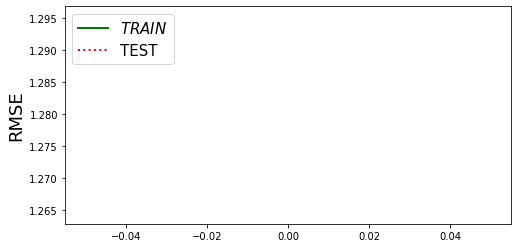

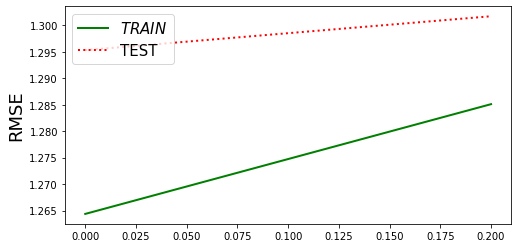

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43146)
Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


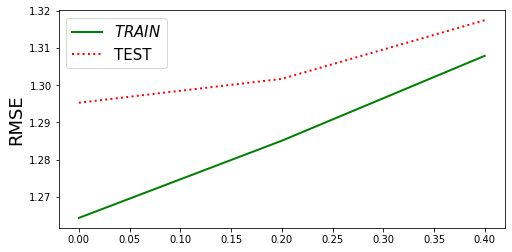

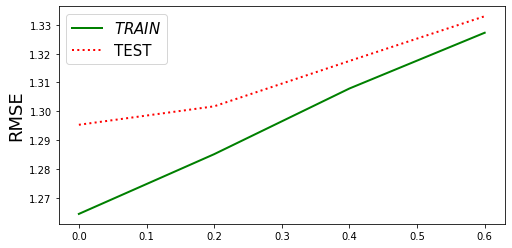

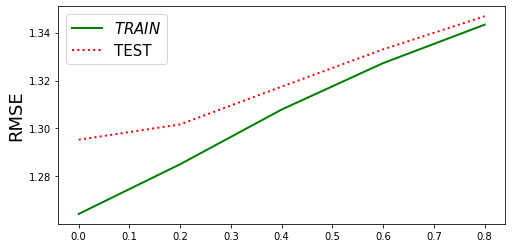

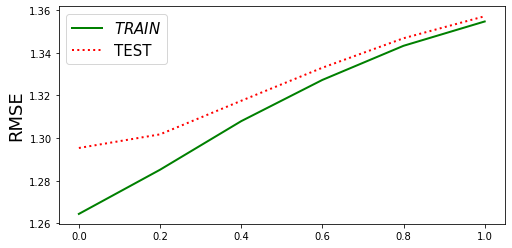

In [6]:
%matplotlib inline

import numpy as np
rng = np.arange(0.0, 2.0, 0.2).tolist()
res = runtest(rng)
print(res)

In [ ]:
x = []
yTrain = []
yTest = []
for v in res:
    x.append(v[0])
    yTrain.append(v[1])
    yTest.append(v[2])

print(yTest)

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(x, yTrain, "g-", linewidth=2, label=r"$TRAIN$")
plt.plot(x, yTest, "r:", linewidth=2, label=r"TEST")
plt.legend(loc="upper left", fontsize=15)
plt.ylabel("RMSE", fontsize=18)